In [1]:
!pip install -q transformers torch pillow
!pip install -q gTTS
!pip install -q transformers torch accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.4 MB/s eta 0:00:00


In [2]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from PIL import Image
import cv2
import numpy as np
from tqdm import tqdm
import os
from google.colab import files
from google.colab import drive
import seaborn as sns
import torch
import json
from transformers import ViTImageProcessor, ViTModel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn.functional as F
from transformers import pipeline
from difflib import get_close_matches
from gtts import gTTS
from IPython.display import Audio, display

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
directory_path = "/content/drive/MyDrive/dataset"

In [5]:
path = "/content/dataset"

In [6]:
if os.path.exists(directory_path):
  !cp -r "$directory_path" "/content"
else:
  print("Error")

In [7]:
train_path = "/content/dataset/train"
test_path = "/content/dataset/test"

In [8]:
os.listdir(train_path)

['yerebatan_sarnici',
 'izmir_saat_kulesi',
 'rumeli_hisari',
 'galata_kulesi',
 'mevlana_muzesi',
 'anitkabir',
 '.DS_Store',
 'sultan_ahmet_camii',
 'kiz_kulesi',
 'sumela_manastiri',
 'ayasofya_camii',
 'topkapi_sarayi']

In [9]:
os.listdir(test_path)

['yerebatan_sarnici',
 'izmir_saat_kulesi',
 'rumeli_hisari',
 'galata_kulesi',
 'mevlana_muzesi',
 'anitkabir',
 '.DS_Store',
 'sultan_ahmet_camii',
 'kiz_kulesi',
 'sumela_manastiri',
 'ayasofya_camii',
 'topkapi_sarayi']

In [10]:
train_list = os.listdir(train_path)

In [11]:
train_list

['yerebatan_sarnici',
 'izmir_saat_kulesi',
 'rumeli_hisari',
 'galata_kulesi',
 'mevlana_muzesi',
 'anitkabir',
 '.DS_Store',
 'sultan_ahmet_camii',
 'kiz_kulesi',
 'sumela_manastiri',
 'ayasofya_camii',
 'topkapi_sarayi']

In [12]:
train_list = [d for d in os.listdir(train_path) if not d.startswith(".")]
train_list

['yerebatan_sarnici',
 'izmir_saat_kulesi',
 'rumeli_hisari',
 'galata_kulesi',
 'mevlana_muzesi',
 'anitkabir',
 'sultan_ahmet_camii',
 'kiz_kulesi',
 'sumela_manastiri',
 'ayasofya_camii',
 'topkapi_sarayi']

In [13]:
test_list = [d for d in os.listdir(test_path) if not d.startswith(".")]
test_list

['yerebatan_sarnici',
 'izmir_saat_kulesi',
 'rumeli_hisari',
 'galata_kulesi',
 'mevlana_muzesi',
 'anitkabir',
 'sultan_ahmet_camii',
 'kiz_kulesi',
 'sumela_manastiri',
 'ayasofya_camii',
 'topkapi_sarayi']

In [14]:
len(train_list)

11

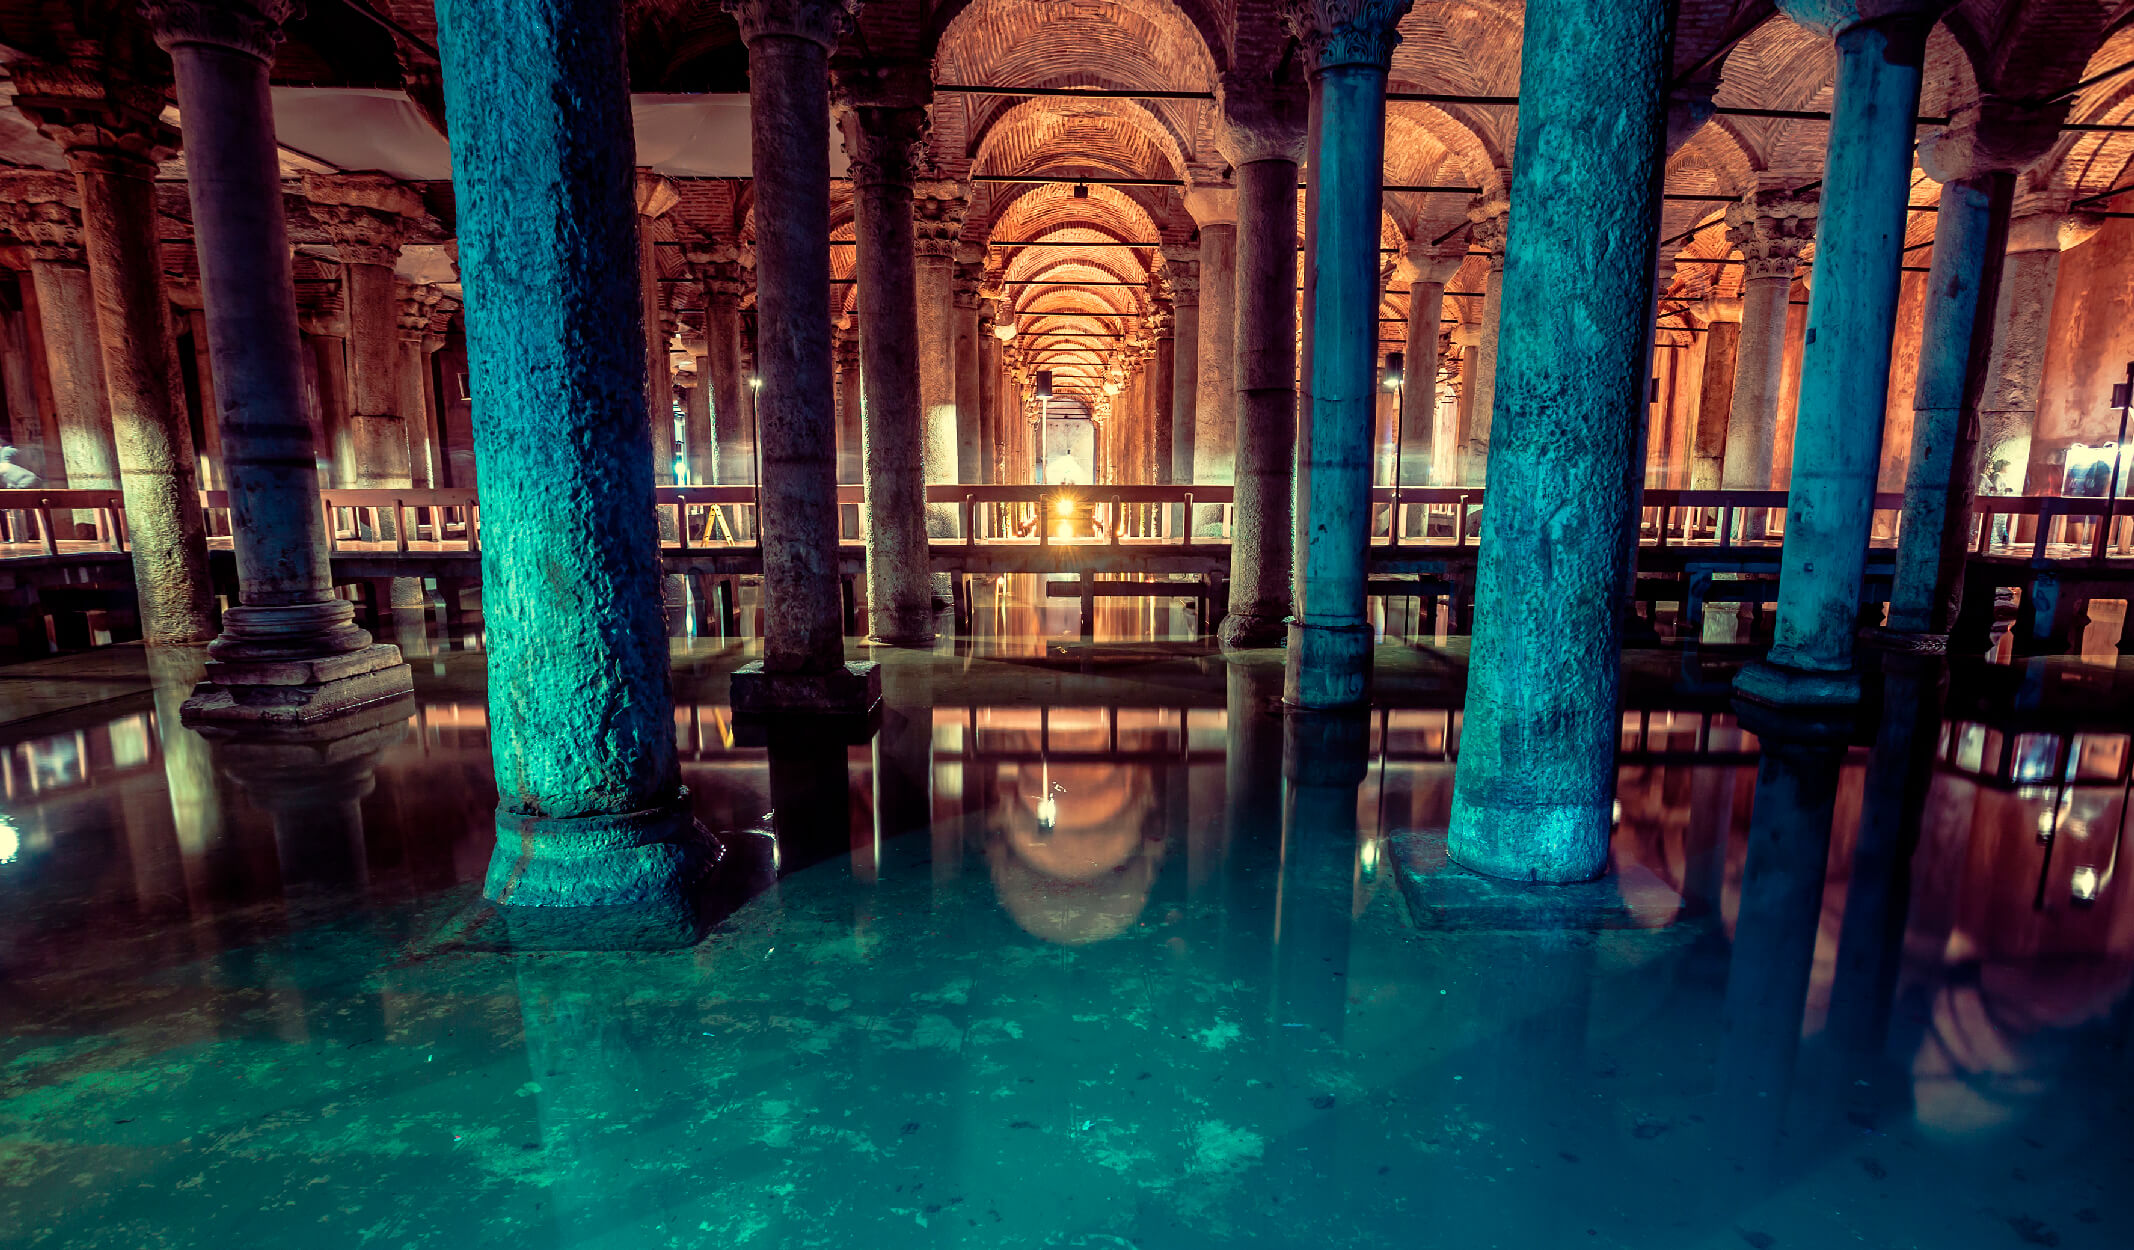

In [15]:
first_image_path = train_path + "/"+ train_list[0] + "/" + "000001.jpg"
image = Image.open(first_image_path)
display(image)

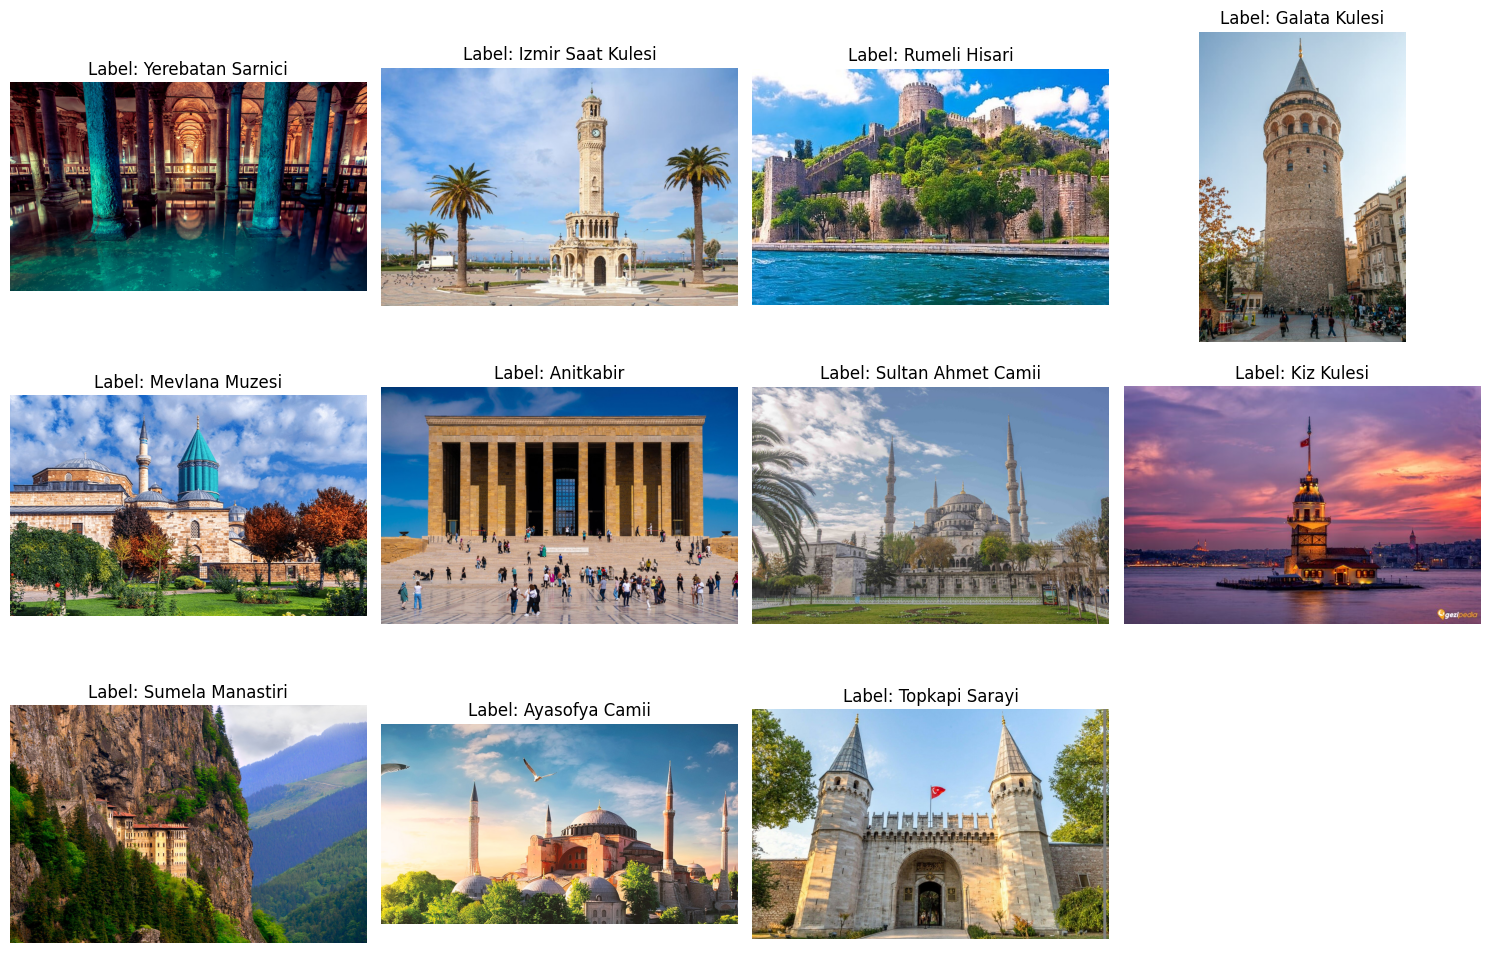

In [16]:
plt.figure(figsize=(15, 10))

for i in range(11):
    if i < len(train_list):
        image_name = train_list[i]
        image_path = os.path.join(train_path, image_name, "000001.jpg")
        img_data = mpimg.imread(image_path)

        image_name = image_name.replace("_", " ").title()
        plt.subplot(3, 4, i + 1)
        plt.imshow(img_data)
        plt.title(f"Label: {image_name}")
        plt.axis("off")

plt.tight_layout()
plt.show()

In [18]:
def preprocess_image(img, size):
    resized_image = cv2.resize(img, size, interpolation=cv2.INTER_LANCZOS4)
    return resized_image

In [19]:
size = (224, 224)

preprocessed_train = "/content/preprocessed_dataset/train"
preprocessed_test = "/content/preprocessed_dataset/test"

os.makedirs(preprocessed_train, exist_ok=True)
os.makedirs(preprocessed_test, exist_ok=True)

for class_name in train_list:
  train_class_dest = os.path.join(preprocessed_train, class_name)
  test_class_dest = os.path.join(preprocessed_test, class_name)

  os.makedirs(train_class_dest, exist_ok=True)
  os.makedirs(test_class_dest, exist_ok=True)

  current_train_source = os.path.join(train_path, class_name)
  current_test_source = os.path.join(test_path, class_name)

  if os.path.exists(current_train_source):
    image_train = os.listdir(current_train_source)

    for img_name in image_train:
      source_path = os.path.join(current_train_source, img_name)
      destination_path = os.path.join(train_class_dest, img_name)

      img = cv2.imread(source_path)

      preprocessed_img = preprocess_image(img, size)
      cv2.imwrite(destination_path, preprocessed_img)

  if os.path.exists(current_test_source):
    images_test = os.listdir(current_test_source)

    for img_name in images_test:
      source_path = os.path.join(current_test_source, img_name)
      destination_path = os.path.join(test_class_dest, img_name)

      img = cv2.imread(source_path)

      preprocessed_img = preprocess_image(img, size)
      cv2.imwrite(destination_path, preprocessed_img)

In [20]:
train_dir = "/content/preprocessed_dataset/train"
test_dir = "/content/preprocessed_dataset/test"

In [21]:
output_file = "landmark_vectors.pt"

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [74]:
model= "google/vit-base-patch16-224"

processor = ViTImageProcessor.from_pretrained(model)
model = ViTModel.from_pretrained(model).to(device)
model.eval()

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
          (d

In [24]:
class_names = os.listdir(train_dir)
class_names

['yerebatan_sarnici',
 'izmir_saat_kulesi',
 'rumeli_hisari',
 'galata_kulesi',
 'mevlana_muzesi',
 'anitkabir',
 'sultan_ahmet_camii',
 'kiz_kulesi',
 'sumela_manastiri',
 'ayasofya_camii',
 'topkapi_sarayi']

In [26]:
reference_database = {}

for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)

  images = os.listdir(class_path)

  for img in images:
    img_path = os.path.join(class_path, img)

    image = Image.open(img_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
      outputs = model(**inputs)

    embedding = outputs.last_hidden_state[:, 0, :].cpu()
    reference_database[class_name] = embedding

torch.save(reference_database, output_file)

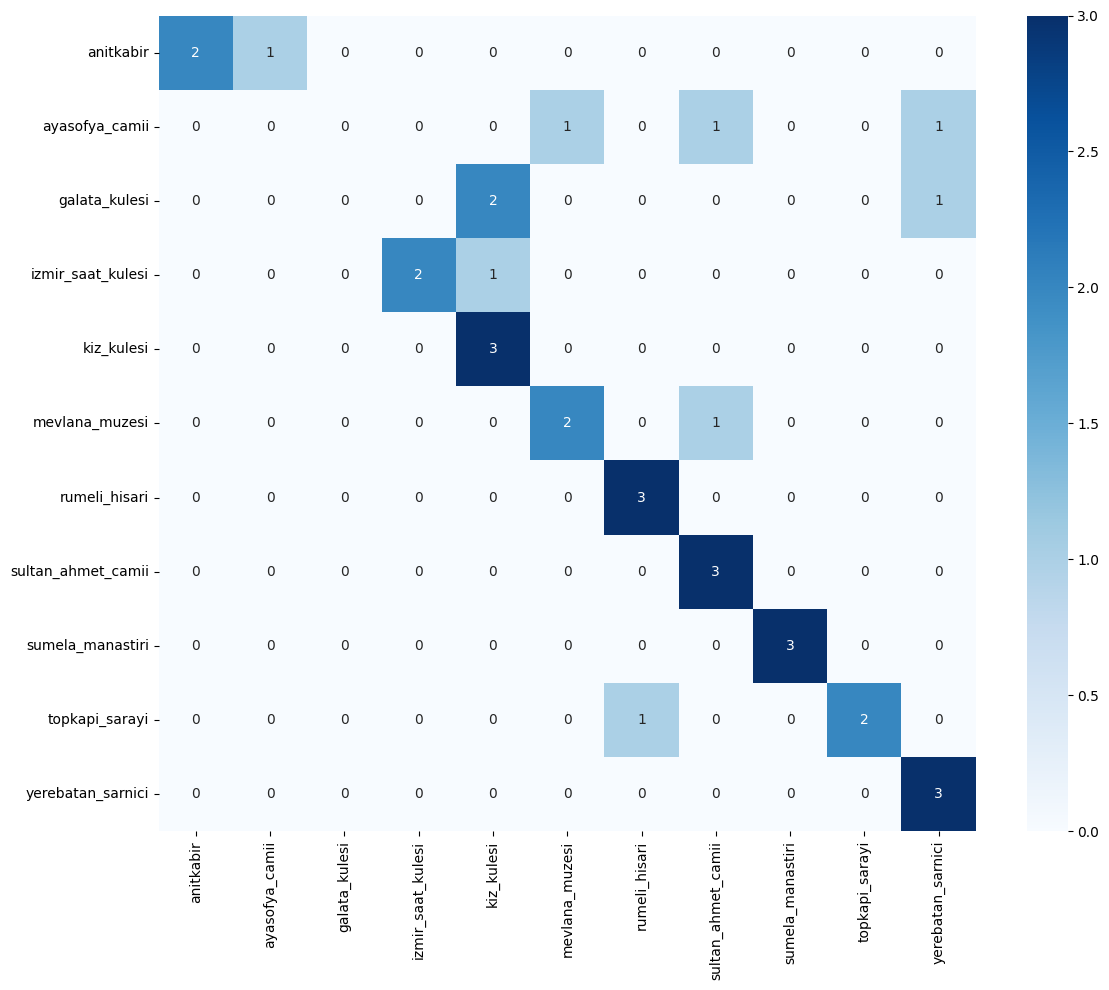

In [28]:
y_true = []
y_pred = []
classes = sorted(list(reference_database.keys()))

for class_name in classes:
  class_path = os.path.join(test_dir, class_name)

  images = os.listdir(class_path)
  for image in images:

    img_path = os.path.join(class_path, image)


    image = Image.open(img_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
      outputs = model(**inputs)

      query_vec = outputs.last_hidden_state[:, 0, :].view(-1)

      best_score = -1.0
      predicted_label = "Unknown"

      for ref_name, ref_vec in reference_database.items():
        ref_vec = ref_vec.to(device).view(-1)
        score = torch.nn.functional.cosine_similarity(query_vec, ref_vec, dim=0).item()

        if score > best_score:
          best_score = score
          predicted_label = ref_name

    y_true.append(class_name)
    y_pred.append(predicted_label)



if y_true:
  plt.figure(figsize=(12, 10))
  cm = confusion_matrix(y_true, y_pred, labels=classes)
  sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes)
  plt.xticks(rotation=90)
  plt.tight_layout()
  plt.show()

In [40]:
database = "turkish_landmarks_knowledge_base.json"

In [51]:
llm_model = "facebook/mbart-large-50-many-to-many-mmt"

In [82]:
summerizer = pipeline("summarization", model=llm_model, device=device)

Device set to use cuda


In [77]:
def normalize_name(name):
  return name.lower().replace("_", " ").strip()

In [78]:
def get_landmark_info(predicted_label, knowledge_db, json_keys):
  clean_pred = normalize_name(predicted_label)
  clean_keys = [normalize_name(k) for k in json_keys]

  matches = get_close_matches(clean_pred, clean_keys, n=1, cutoff=0.5)

  if matches:
    match_index = clean_keys.index(matches[0])
    real_key = json_keys[match_index]
    return knowledge_db[real_key]
  return None

In [ ]:
def predict_landmark(image_path, model, processor, reference_db):
  image = Image.open(image_path).convert("RGB")
  inputs = processor(images=image, return_tensors="pt").to(device)

  with torch.no_grad():
    outputs = model(**inputs)

  query_vec = outputs.last_hidden_state[:, 0, :].view(-1)

  best_score = -1.0
  predicted_label = "Unknown"

  for ref_name, ref_vec in reference_db.items():
    ref_vec = ref_vec.to(device).view(-1)
    score = torch.nn.functional.cosine_similarity(query_vec, ref_vec, dim=0).item()

    if score > best_score:
      best_score = score
      predicted_label = ref_name

  return image, predicted_label, best_score

In [79]:
def generate_summary(info, summarizer_pipeline, lang='tr'):
  full_text = info.get('full_text', '') or info.get('summary', '')

  if lang == 'en':
    prompt_prefix = "Summarize this text in English: "
  else:
    prompt_prefix = "Aşağıdaki metni Türkçe özetle: "

  input_text = full_text[:2000]
  final_prompt = prompt_prefix + input_text


  summary_output = summarizer_pipeline(
      final_prompt,
      max_length=150,
      min_length=40,
      do_sample=False,
      truncation=True
  )
  return summary_output[0]['summary_text']

In [80]:
def speak_text(text, lang='tr'):
    if not text or len(text) < 5:
      return

    filename = f"summary_{lang}.mp3"

    tts = gTTS(text=text, lang=lang, slow=False)
    tts.save(filename)
    display(Audio(filename, autoplay=True))

In [81]:
def display_results(image, label, score, summary_text):
  plt.figure(figsize=(8, 5))
  plt.imshow(image)
  plt.axis('off')
  plt.title(f"{label}\nConf: {score:.2f}", fontsize=14, fontweight='bold', color='darkblue')
  plt.show()

In [ ]:
def run_full_pipeline(image_path):
  img, label, score = predict_landmark(image_path, model, processor, reference_database)

  info = get_landmark_info(label, knowledge_db, json_keys)

  lang_input = input("Language (TR/EN)? ").strip().lower()
  selected_lang = 'en' if lang_input in ['en', 'english', 'ing'] else 'tr'

  summary_text = generate_summary(info, pipeline, lang=selected_lang)

  clear_output(wait=True)
  display_results(img, label, score, summary_text)
  speak_text(summary_text, lang=selected_lang)


uploaded = files.upload()
for filename in uploaded.keys():
  run_full_pipeline(filename)